In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Compute the time elapsed
"""
def tic():
    global tic_time
    tic_time = time.time()
    
def toc():
    return time.time() - tic_time

In [3]:
"""
Load MNIST data
Return: all images and labels of train, validation, test dataset
"""
def load_data():
    mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
    data = {
        'train_images': mnist.train.images.reshape(-1, 28, 28, 1).astype(np.float32),
        'train_labels': mnist.train.labels.astype(np.float32),
        'validation_images': mnist.validation.images.reshape(-1, 28, 28, 1).astype(np.float32),
        'validation_labels': mnist.validation.labels.astype(np.float32),
        'test_images': mnist.test.images.reshape(-1, 28, 28, 1).astype(np.float32),
        'test_labels': mnist.test.labels.astype(np.float32)
    }
    return data

In [4]:
"""
Define Discriminator
"""
def discriminator(images_input, labels_input, image_H, image_W, label_size, n_1, n_2, n_3, n_4, n_out, is_training, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        inputs = tf.concat([images_input, tf.tile(tf.reshape(labels_input, (-1, 1, 1, label_size)), (1, image_H, image_W, 1))], 3, name='inputs')
        Z1 = tf.contrib.layers.conv2d(inputs, n_1, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z1')
        A1 = tf.nn.leaky_relu(Z1, name='A1')
        Z2 = tf.contrib.layers.conv2d(A1, n_2, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z2')
        Z2_bn = tf.layers.batch_normalization(Z2, training=is_training, name='Z2_bn')
        A2 = tf.nn.leaky_relu(Z2_bn, name='A2')
        Z3 = tf.contrib.layers.conv2d(A2, n_3, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z3')
        Z3_bn = tf.layers.batch_normalization(Z3, training=is_training, name='Z3_bn')
        A3 = tf.nn.leaky_relu(Z3_bn, name='A3')
        Z4 = tf.contrib.layers.conv2d(A3, n_4, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z4')
        Z4_bn = tf.layers.batch_normalization(Z4, training=is_training, name='Z4_bn')
        A4 = tf.nn.leaky_relu(Z4_bn, name='A4')
        A4_flatten = tf.contrib.layers.flatten(A4, scope='A4_flatten')
        Z_out = tf.contrib.layers.fully_connected(A4_flatten, n_out, activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z_out')
    return Z_out

In [5]:
"""
Define Generator
"""
def generator(noises_input, labels_input, n_1, n_2, n_3, n_4, n_out, is_training):
    with tf.variable_scope('generator'):
        inputs = tf.concat([noises_input, labels_input], 1, name='inputs')
        Z1 = tf.contrib.layers.fully_connected(inputs, 4 * 4 * n_1, activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z1')
        Z1_reshape = tf.reshape(Z1, (-1, 4, 4, n_1), name='A1_reshape')
        Z1_bn = tf.layers.batch_normalization(Z1_reshape, training=is_training, name='Z1_bn')
        A1 = tf.nn.relu(Z1_bn, name='A1')
        Z2 = tf.contrib.layers.conv2d_transpose(A1, n_2, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z2')
        Z2_bn = tf.layers.batch_normalization(Z2, training=is_training, name='Z2_bn')
        A2 = tf.nn.relu(Z2_bn, name='A2')
        Z3 = tf.contrib.layers.conv2d_transpose(A2, n_3, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z3')
        Z3_bn = tf.layers.batch_normalization(Z3, training=is_training, name='Z3_bn')
        A3 = tf.nn.relu(Z3_bn, name='A3')
        Z4 = tf.contrib.layers.conv2d_transpose(A3, n_4, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z4')
        Z4_bn = tf.layers.batch_normalization(Z4, training=is_training, name='Z4_bn')
        A4 = tf.nn.relu(Z4_bn, name='A4')
        Z_out = tf.contrib.layers.conv2d_transpose(A4, n_out, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z_out')
        A_out = tf.nn.tanh(Z_out, name='A_out')
    return A_out

In [6]:
"""
Restore the Conditional-DCGAN for MNIST and Generating images
Variable: noises, shape = (num of noise, 100)
          labels, shape = (num of noise, 10) in one hot
"""
def MNIST_Conditioinal_DCGAN_Generator(noises, labels):
    tf.reset_default_graph()
    
    #Restricted Settings#
    noise_size = 100
    generator_n_1 = 1024
    generator_n_2 = 512
    generator_n_3 = 256
    generator_n_4 = 128
    generator_n_out = 1
    discriminator_n_1 = 128
    discriminator_n_2 = 256
    discriminator_n_3 = 512
    discriminator_n_4 = 1024
    discriminator_n_out = 1
    image_H = 64
    image_W = 64
    image_C = 1
    label_size = 10

    #Define placeholders#
    real_images = tf.placeholder(tf.float32, (None, image_H, image_W, image_C), name='real_images')
    noises_input = tf.placeholder(tf.float32, (None, noise_size), name='noises_input')
    labels_input = tf.placeholder(tf.float32, (None, label_size), name='labels_input')
    is_training = tf.placeholder(tf.bool, name='is_training')

    #Define the outputs of generator and discriminator#
    fake_images = generator(noises_input, labels_input, generator_n_1, generator_n_2, generator_n_3, generator_n_4, generator_n_out, is_training)
    real_logits = discriminator(real_images, labels_input, image_H, image_W, label_size, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_4, discriminator_n_out, is_training)
    fake_logits = discriminator(fake_images, labels_input, image_H, image_W, label_size, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_4, discriminator_n_out, is_training, reuse=True)

    #Resize the fake images generated by generator#
    fake_images_resized = tf.image.resize_images(fake_images, [28, 28])
    
    #Generate Images#
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, './dcgan_model_parameters/MNIST_Conditional-DCGAN_model.ckpt')
        generated_images_resized = sess.run(fake_images_resized, feed_dict={noises_input:noises, labels_input:labels, is_training:False})
    tf.reset_default_graph()
    return generated_images_resized.astype(np.float32)

In [7]:
"""
Perform Data Augmentation using MNIST Conditional-DCGAN Generator
Variables: times = times for augmentation
Return: augmented dataset
"""
def data_augmentation(aug_num):
    batch_size = 4096
    aug_labels = np.eye(10)[np.random.randint(0, high=10, size=(aug_num,))].astype(np.float32)
    noises = np.random.uniform(low=-1, high=1, size=(aug_num, 100)).astype(np.float32)
    total_batches = np.ceil(aug_labels.shape[0] / batch_size).astype(np.int32)
    aug_images = np.zeros((aug_num, 28, 28, 1), dtype=np.float32)
    tic()
    for j in range(total_batches):
        print('Data Augmenting: {}/{}'.format(j + 1, total_batches))
        index_front = j * batch_size
        index_end = (j + 1) * batch_size if (j + 1) * batch_size < aug_labels.shape[0] else aug_labels.shape[0]
        aug_images[index_front:index_end] = MNIST_Conditioinal_DCGAN_Generator(noises[index_front:index_end], aug_labels[index_front:index_end])
    print('Time Elapsed for Data Augmentation using Conditional-DCGAN: {:.2f}s'.format(toc()))
    return aug_images, aug_labels

In [8]:
"""
Perform Data Shuffling
"""
def data_shuffling(images, labels):
    shuffle_array = np.random.permutation(images.shape[0])
    images = images[shuffle_array]
    labels = labels[shuffle_array]
    return images, labels

In [9]:
"""
Define the architecture of Convolutional Neural Networks
"""
def cnn_model(images, n_1, n_2, n_3, n_4, n_5, n_6, n_7, n_out, keep_prob_2, keep_prob_6, keep_prob_7, is_training):
    with tf.variable_scope('cnn_model'):
        A1 = tf.contrib.layers.conv2d(images, n_1, 5, scope='A1')
        A2 = tf.contrib.layers.conv2d(A1, n_2, 5, scope='A2')
        A2_maxpool = tf.contrib.layers.max_pool2d(A2, 2, scope='A2_maxpool')
        A2_dropout = tf.contrib.layers.dropout(A2_maxpool, keep_prob=keep_prob_2, is_training=is_training, scope='A2_dropout')
        A3 = tf.contrib.layers.conv2d(A2_dropout, n_3, 5, scope='A3')
        A4 = tf.contrib.layers.conv2d(A3, n_4, 5, scope='A4')
        A5 = tf.contrib.layers.conv2d(A4, n_5, 5, scope='A5')
        A6 = tf.contrib.layers.conv2d(A5, n_6, 5, scope='A6')
        A6_maxpool = tf.contrib.layers.max_pool2d(A6, 2, scope='A6_maxpool')
        A6_dropout = tf.contrib.layers.dropout(A6_maxpool, keep_prob=keep_prob_6, is_training=is_training, scope='A6_dropout')
        A6_flatten = tf.contrib.layers.flatten(A6_dropout, scope='A6_flatten')
        A7 = tf.contrib.layers.fully_connected(A6_flatten, n_7, scope='A7')
        A7_dropout = tf.contrib.layers.dropout(A7, keep_prob=keep_prob_7, is_training=is_training, scope='A7_dropout')
        Z_out = tf.contrib.layers.fully_connected(A7_dropout, n_out, activation_fn=None, scope='Z_out')
    return Z_out

In [10]:
"""
Define and Train Convolutional Neural Networks Model
Return: history of costs
"""
def mnist_cnn(hyperparams):
    tf.reset_default_graph()
    
    #Load, augment and shuffle data#
    data = load_data()
    temp1 = np.zeros(((hyperparams['augment_times'] + 1) * data['train_images'].shape[0], 28, 28, 1), dtype=np.float32)
    temp2 = np.zeros(((hyperparams['augment_times'] + 1) * data['train_labels'].shape[0], 10), dtype=np.float32)
    aug_images, aug_labels = data_augmentation(hyperparams['augment_times'] * data['train_images'].shape[0])
    temp1[0:data['train_images'].shape[0]] = data['train_images']
    temp1[data['train_images'].shape[0]:] = aug_images
    temp2[0:data['train_labels'].shape[0]] = data['train_labels']
    temp2[data['train_labels'].shape[0]:] = aug_labels
    data['train_images'] = temp1
    data['train_labels'] = temp2
    del temp1
    del temp2
    data['train_images'], data['train_labels'] = data_shuffling(data['train_images'], data['train_labels'])
    
    #Hyperparameters settings and properties#
    learning_rate = hyperparams['learning_rate']
    decay_rate = hyperparams['decay_rate']
    decay_steps = hyperparams['decay_steps']
    epoch = hyperparams['epoch']
    keep_prob_2 = hyperparams['keep_prob_2']
    keep_prob_6 = hyperparams['keep_prob_6']
    keep_prob_7 = hyperparams['keep_prob_7']
    n_1 = hyperparams['n_1']
    n_2 = hyperparams['n_2']
    n_3 = hyperparams['n_3']
    n_4 = hyperparams['n_4']
    n_5 = hyperparams['n_5']
    n_6 = hyperparams['n_6']
    n_7 = hyperparams['n_7']
    n_out = hyperparams['n_out']
    batch_size = hyperparams['batch_size']
    train_data_size = data['train_images'].shape[0]
    validation_data_size = data['validation_images'].shape[0]
    test_data_size = data['test_images'].shape[0]
    image_size_H = 28
    image_size_W = 28
    label_size = data['train_labels'].shape[1]
    train_total_batches = np.ceil(train_data_size / batch_size).astype(np.int32)
    
    #Define placeholders#
    images_input = tf.placeholder(tf.float32, (None, image_size_H, image_size_W, 1), name='images_input')
    labels = tf.placeholder(tf.float32, (None, label_size), name='labels')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    #Define model#
    model_out = cnn_model(images_input, n_1, n_2, n_3, n_4, n_5, n_6, n_7, n_out, keep_prob_2, keep_prob_6, keep_prob_7, is_training)
    
    #Define Cost, Predictions, Comparisons and Accuracy#
    softmax_cost = tf.nn.softmax_cross_entropy_with_logits(logits=model_out, labels=labels, name='softmax_cost')
    cost_sum = tf.reduce_sum(softmax_cost, name='cost_sum')
    cost_mean = tf.reduce_mean(softmax_cost, name='cost_mean')
    predictions = tf.argmax(model_out, axis=-1, name='predictions')
    labels_sparse = tf.argmax(labels, axis=-1, name='labels_sparse')
    comparisons = tf.cast(tf.equal(predictions, labels_sparse, name='pred_labels_comparison_bool'), tf.float32, name='pred_labels_comparison_float32')
    accuracy_sum = tf.reduce_sum(comparisons, name='accuracy_sum')
    accuracy_mean = tf.reduce_mean(comparisons, name='accuracy_mean')
    
    #Compute decayed learning rate#
    global_step = tf.Variable(0, trainable=False, name='global_step', dtype=tf.int32)
    decayed_learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False, name='decayed_learning_rate')
    
    #Define optimizer#
    opt_minimize = tf.train.AdamOptimizer(learning_rate=decayed_learning_rate, name='optimizer').minimize(cost_mean, global_step=global_step, name='opt_minimize')
    
    #Training#
    costs_history = {
        'train_cost_iter': [],
        'validation_cost_iter': []
    }
    accuracies_history = {
        'train_acc_iter': [],
        'validation_acc_iter': []
    }
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch):
            tic()
            
            #Reset the accumulators#
            train_cost_epoch = 0.
            train_acc_epoch = 0.
            validation_cost_epoch = 0.
            validation_acc_epoch = 0.
            for j in range(train_total_batches):
                print('Epoch {}/{}, Training Batch: {}/{}'.format(i + 1, epoch, j + 1, train_total_batches), end='\r')
                index_front = j * batch_size
                index_end = (j + 1) * batch_size if (j + 1) * batch_size < train_data_size else train_data_size
                images_batch = data['train_images'][index_front:index_end]
                labels_batch = data['train_labels'][index_front:index_end]
                current_batch_size = index_end - index_front
                
                #Update parameters of the model#
                _, train_cost_iter, train_acc_iter = sess.run([opt_minimize, cost_sum, accuracy_sum], feed_dict={images_input:images_batch, labels:labels_batch, is_training:True})
                
                #Run on validation set#
                validation_cost_mean_iter, validation_acc_mean_iter = sess.run([cost_mean, accuracy_mean], feed_dict={images_input:data['validation_images'], labels:data['validation_labels'], is_training:False})
                
                #Compute and save the average(likely) costs and accuracies#
                train_cost_epoch += train_cost_iter / train_data_size
                train_acc_epoch += train_acc_iter / train_data_size
                train_cost_mean_iter = train_cost_iter / current_batch_size
                train_acc_mean_iter = train_acc_iter / current_batch_size
                costs_history['train_cost_iter'].append(train_cost_mean_iter)
                costs_history['validation_cost_iter'].append(validation_cost_mean_iter)
                accuracies_history['train_acc_iter'].append(train_acc_mean_iter)
                accuracies_history['validation_acc_iter'].append(validation_acc_mean_iter)
                
            #Print the state every epoch#
            print('Epoch {}/{} Time Elapsed: {:.2f}s'.format(i + 1, epoch, toc()))
            print('Training Cost: {:.8f} Validation Cost: {:.8f} Training Accuracy: {:.4f} Validation Accuracy: {:.4f}'.format(train_cost_epoch, costs_history['validation_cost_iter'][-1], train_acc_epoch, accuracies_history['validation_acc_iter'][-1]))
        
        #Print the accuracy of running on test set#
        test_acc = sess.run(accuracy_mean, feed_dict={images_input:data['test_images'], labels:data['test_labels'], is_training:False})
        print('Testing Accuracy: {:.4f}'.format(test_acc))
    return costs_history, accuracies_history

In [11]:
"""
Show graphs of costs
"""
def show_costs_graphs(costs_history, ewma_span=10):
    plt.figure(figsize=(20, 10))
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
    plt.title('Cost - Iteration')
    plt.plot(costs_history['train_cost_iter'], 'b-', alpha=0.3, label='Training Cost')
    plt.plot(costs_history['validation_cost_iter'], 'r-', alpha=0.3, label='Validation Cost')
    ewma_train_cost_iter = pd.stats.moments.ewma(np.array(costs_history['train_cost_iter']), span=ewma_span)
    plt.plot(ewma_train_cost_iter, 'b-', label='Training Cost EWMA')
    ewma_val_cost_iter = pd.stats.moments.ewma(np.array(costs_history['validation_cost_iter']), span=ewma_span)
    plt.plot(ewma_val_cost_iter, 'r-', label='Validation Cost EWMA')
    plt.legend(loc='best')
    plt.show()

In [12]:
"""
Show graphs of accuracies
"""
def show_accs_graphs(accuracies_history, ewma_span=10):
    plt.figure(figsize=(20, 10))
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.title('Accuracy - Iteration')
    plt.plot(accuracies_history['train_acc_iter'], 'b-', alpha=0.3, label='Training Accuracy')
    plt.plot(accuracies_history['validation_acc_iter'], 'r-', alpha=0.3, label='Validation Accuracy')
    ewma_train_cost_iter = pd.stats.moments.ewma(np.array(accuracies_history['train_acc_iter']), span=ewma_span)
    plt.plot(ewma_train_cost_iter, 'b-', label='Training Accuracy EWMA')
    ewma_val_cost_iter = pd.stats.moments.ewma(np.array(accuracies_history['validation_acc_iter']), span=ewma_span)
    plt.plot(ewma_val_cost_iter, 'r-', label='Validation Accuracy EWMA')
    plt.legend(loc='best')
    plt.show()

In [13]:
"""
Define the hyperparameters
"""
hyperparams={
    'learning_rate': 0.001,
    'decay_rate': 0.95,
    'decay_steps': 2149,
    'epoch': 100,
    'keep_prob_2': 0.75,
    'keep_prob_6': 0.75,
    'keep_prob_7': 0.5,
    'n_1': 32,
    'n_2': 32,
    'n_3': 64,
    'n_4': 64,
    'n_5': 64,
    'n_6': 64,
    'n_7': 512,
    'n_out': 10,
    'batch_size': 128,
    'augment_times': 4
}
costs_history, accuracies_history = mnist_cnn(hyperparams)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Data Augmenting: 1/54
INFO:tensorflow:Restoring parameters from ./dcgan_model_parameters/MNIST_Conditional-DCGAN_model.ckpt
Data Augmenting: 2/54
INFO:tensorflow:Restoring parameters from ./dcgan_model_parameters/MNIST_Conditional-DCGAN_model.ckpt
Data Augmenting: 3/54
INFO:tensorflow:Restoring parameters from ./dcgan_model_parameters/MNIST_Conditional-DCGAN_model.ckpt
Data Augmenting: 4/54
INFO:tensorflow:Restoring parameters from ./dcgan_model_parameters/MNIST_Conditional-DCGAN_model.ckpt
Data Augmenting: 5/54
INFO:tensorflow:Restoring parameters from ./dcgan_model_parameters/MNIST_Conditional-DCGAN_model.ckpt
Data Augmenting: 6/54
INFO:tensorflow:Restoring parameters from ./dcgan_model_parameters/MNIST_Conditional-DCGAN_model.ckpt
Data Augmenting: 7/54
INFO:tensorflow:Restoring parameters fro

Epoch 65/100 Time Elapsed: 317.83s/2149
Training Cost: 0.00006159 Validation Cost: 0.09364410 Training Accuracy: 1.0000 Validation Accuracy: 0.9950
Epoch 66/100 Time Elapsed: 317.85s/2149
Training Cost: 0.00010508 Validation Cost: 0.08731158 Training Accuracy: 1.0000 Validation Accuracy: 0.9946
Epoch 67/100 Time Elapsed: 317.83s/2149
Training Cost: 0.00007505 Validation Cost: 0.09010354 Training Accuracy: 1.0000 Validation Accuracy: 0.9950
Epoch 68/100 Time Elapsed: 317.79s/2149
Training Cost: 0.00004166 Validation Cost: 0.08980919 Training Accuracy: 1.0000 Validation Accuracy: 0.9950
Epoch 69/100 Time Elapsed: 317.79s/2149
Training Cost: 0.00012643 Validation Cost: 0.08855808 Training Accuracy: 1.0000 Validation Accuracy: 0.9950
Epoch 70/100 Time Elapsed: 317.85s/2149
Training Cost: 0.00001871 Validation Cost: 0.08924054 Training Accuracy: 1.0000 Validation Accuracy: 0.9952
Epoch 71/100 Time Elapsed: 317.79s/2149
Training Cost: 0.00006846 Validation Cost: 0.08627436 Training Accuracy:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]


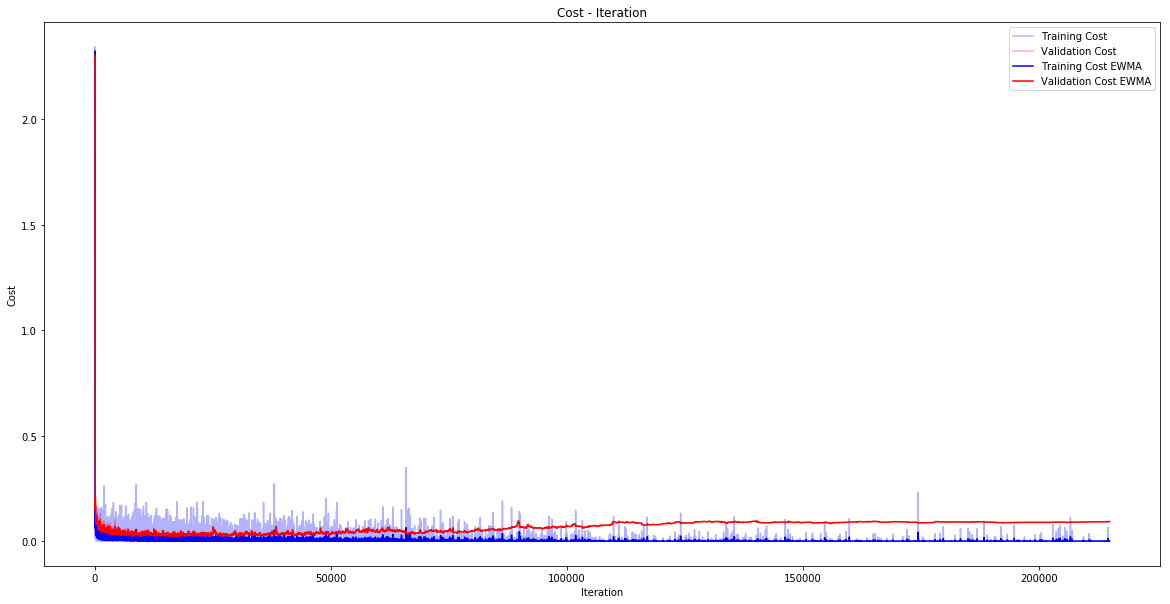

In [14]:
show_costs_graphs(costs_history)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]


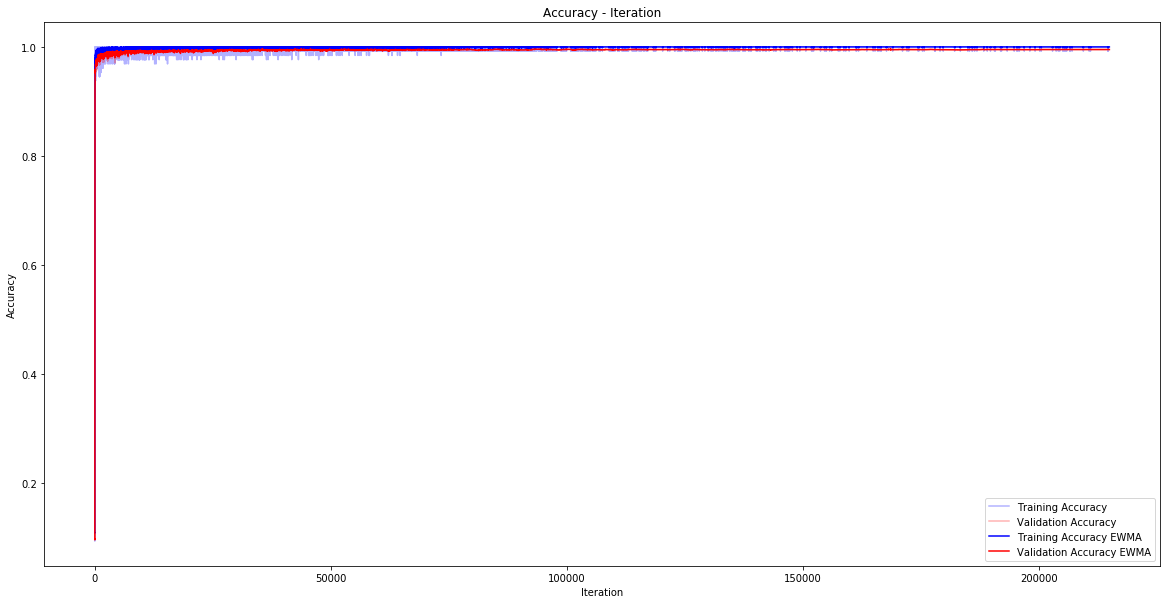

In [15]:
show_accs_graphs(accuracies_history)